# Correlation Power Analysis (CPA)

This more powerful attack allows to quickly retrieve keys. You will use datasets already acquired in DPA lab session and demonstrate that CPA is indeed much faster, that it requires fewer traces. 

## Set-up + Data sets

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import time

from tqdm.notebook import trange

In [2]:
# AES SBOX as an array
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16], dtype=int)

 ### Load and select datasets on which you will work

In [3]:
# load traces
traces_exp = np.load("./acqui/tracesAES.npy")
plaintexts_exp = np.load("./acqui/plaintexts.npy")

traces_simu = np.load("./simu/traces_simu.npy")
plaintexts_simu  = np.load("./simu/plaintexts.npy")

In [5]:
traces = traces_simu
messages = plaintexts_simu

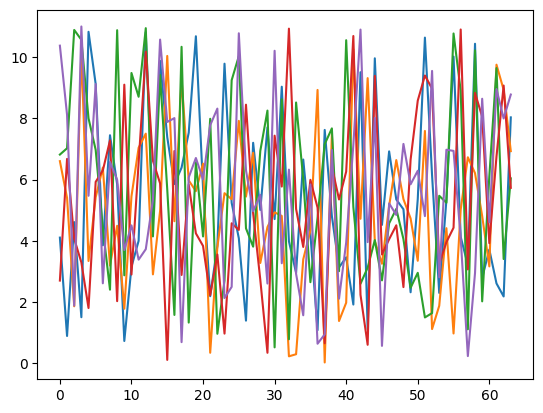

In [6]:
plt.plot(traces_simu[:5].T)
plt.show()

In [7]:
print(plaintexts_simu[:5])

[[252 216  49  40 223 127 209  53 118 251  73 247  29 175  38 102]
 [ 78 177  11   7 157  75  32   1 138 103  10 230  81  13  55  70]
 [ 29 152   2 228  96 179 196  80 236 132 236  99  75 162   3 146]
 [235  94  68 113 227  75  15  94 170 233 165 221 177 157 233 255]
 [134  77 234 121  60 150 154 216 214 192  37  80  97 236  32  92]]


## CPA  implementation

CPA measures the correlation between a specific expected/theoretical model and the actual/experimental traces. For a given key guess, the higher the correlation, the more likely the key guess is.
As in DPA attack, we will work byte per byte (divide and conquer strategy) and target the same output (after the first SBox).

The figure belows shows the principle and steps of this attack, where HW is the Hamming Weight (see below).
![CPA Attack](CPA.png)

###  Hamming Weight leakage model

In this lab, we will use the [hamming weight](https://en.wikipedia.org/wiki/Hamming_weight) (or **HW**) leakage which is the more common leakage model. 
1. Define the `hamming_weight` function which outputs the number of "1" in the binary reprensentation of a number. 


In [10]:
def hamming_weight(x):
    result = 0
    while x:
        result += x & 1
        x >>= 1
    return result

Sanity checks

In [11]:
assert(hamming_weight(0b10111011) == 6)
assert(hamming_weight(0x55) == 4)

2. Define `sel_hamming` which returns the `hamming_weight` of the target, *i.e.* HW of the ouput of the first SBox, with a known `message` (16 bytes) , key `guess` (1 single byte) for a specific `byte` position (from 0 to 15).

In [20]:
def sel_hamming(message, guess, byte):
    result = 0
    output = SBOX[message[byte] ^ guess]
    result = hamming_weight(output)
    return result

In [21]:
# Remark : this only works when using the simu traces !
assert(sel_hamming(messages[0], 0, 0) == 3)
assert(sel_hamming(messages[2], 0x65, 4) == 5)

Now you can calculate this hamming weight for all the messages, and obtain the vector at the right hand side of the CPA schematics. 

2. Compute the value of the leakage model vector for all the messages for a given key guess. 


In [23]:
def leakage_model(messages, guess, byte):
    result=np.zeros(len(messages))
    # TODO: return a np.array containing the leakage model for all the messages (for a given key guess)
    for i in range(len(messages)):
        result[i] = sel_hamming(messages[i], guess, byte)
    return result

### Correlation

CPA measures the correlation between experiments and the leakage model. We will first implement this correlation at one time position and then extrapolates this correlation for all time samples. 

#### Correlation coefficient of 2 vectors

We will use [Pearson `correlation`](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) coefficient to measure the correlation between 2 vectors of lenght $N$,  $X = \sum_i X_i$ and $Y = \sum_i Y_i$. This coefficient corresponds to a normalized covariance of the 2 vectors:

$$ corr = \frac{cov(X, Y)} {\sigma_X \sigma_Y} $$

where 

$$ \sigma_X = \sqrt{var(X)} =  \sqrt{\sum_i (X_i - \bar{X})^2}$$ where $$  \bar{X} = 1/N \sum_{i=0}^{N-1} X_i $$
and 

$$ cov(X, Y) = \frac{1}{N} \sum_i (X_i - \bar{X})(Y_i - \bar{Y})  $$

You can use numpy functions `np.mean`, `np.var`, `np.sqrt` to calculate the corr coefficient as they are faster and optimized for vectors. 

In [51]:
def corr(xv,yv):
    ''' xv, yv vectors
    returns scalar, correlation coefficient of the two vectors
    '''
    N = len(xv)
    var_x = np.var(xv)
    var_y = np.var(yv)
    mean_x = np.mean(xv)
    mean_y = np.mean(yv)
    sum = np.sum((xv - mean_x)*(yv - mean_y))
    cov_xy = (1/N)*(sum)
    corr = cov_xy/((np.sqrt(var_x)*np.sqrt(var_y)))
    return corr

Sanity check : asserting that correlation respects some properties...

1.0


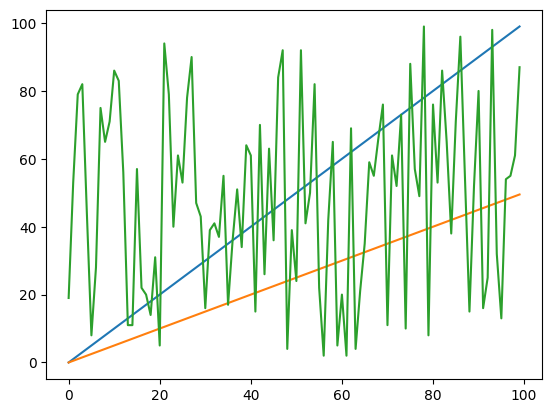

In [52]:
a = np.arange(100)
b = 0.5 * np.arange(100)
c = np.random.randint(0, 100, 100)
print(corr(a,b))
assert(corr(a,b) == 1)
assert(corr(a,c) < 0.2)
plt.figure()
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.show()

### Correlation between traces and leakage model

Calculate the correlation function for **byte 0** at **time position 18** in the simulated traces for all possible key guesses, and retrieve the correct key. This corresponds to the leakage scalar in the CPA figure. 


In [44]:
def correlation(guess, time_pos, byte):
    leak_mod = leakage_model(messages, guess, byte)
    vector_time_pos = traces[:, time_pos]
    result = corr(leak_mod, vector_time_pos)
    return result

In [45]:
def correlation_guesses(guesses, time_pos, byte):
    results = []
    # TODO: return a vector of correlation for every key guesses
    for guess in guesses:
        results.append(correlation(guess, time_pos, byte))
    return np.array(results)

Correct key byte is: 32


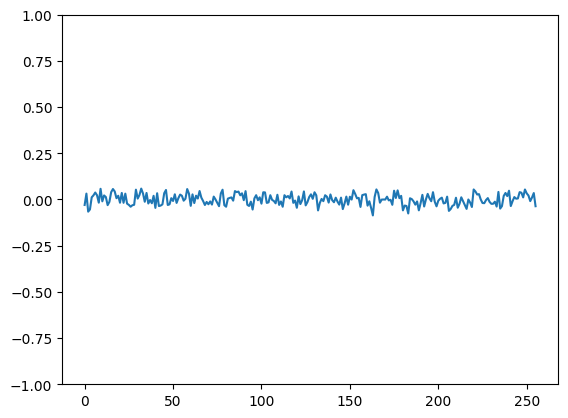

In [49]:
print("Correct key byte is:", correlation_guesses(np.arange(256), 18, 0).argmax())

plt.plot(correlation_guesses(np.arange(256), 18, 0))
plt.ylim(-1,1)
plt.show()

In order to complete the correlation vector, we need to compute this correlation vector for all time position. You could do this with a loop, but we would better use **numpy acceleration** and use the same functions with an axis parameters. 

For instance `traces.sum(axis=0)` will calculate the mean value of the columns of the traces, which correponds to the mean value at a given time position. This is what we need.
The only issue might be the leakage model vector which is not a matrix, but you can convert it to a matrix by returning an `np.array` of leakage models. 

In [92]:
def corr_vect(xmat, ymat):
    ''' xmat (vector), ymat(matrix)
    returns vector correlation coefficient of the two matrices
    '''
    N = xmat.shape[1]
    var_y = np.var(ymat, axis=0)
    var_x = np.var(xmat)
    mean_x = np.mean(xmat)
    mean_y = np.mean(ymat, axis=0)
    cov_xy = np.zeros(ymat.shape[1])
    for i in range(ymat.shape[1]):
        sum = np.sum((xmat - mean_x)*(ymat[:,i] - mean_y[i]))
        cov_xy[i] = (1/N)*(sum)
    result = cov_xy/((np.sqrt(var_x)*np.sqrt(var_y)))
    return result

In [93]:
def guess_correlation(guess, messages, traces, leakage_fnct):
    # TODO: compute correlation for every time positions and a specific guess
    leakage_matrix = np.array([leakage_fnct(messages, guess)])
    result = corr_vect(leakage_matrix, traces)
    return result

Sanity plot checks

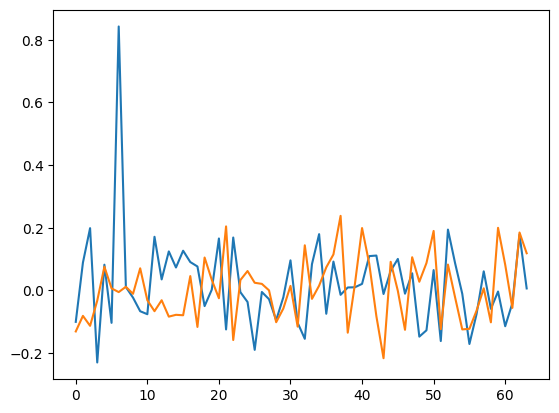

In [94]:
nb_traces = 100
res = guess_correlation(0, messages[:nb_traces,:], traces[:nb_traces,:], lambda m,g :leakage_model(m, g, 0))
plt.plot(res)
res = guess_correlation(0x61, messages[:nb_traces,:], traces[:nb_traces,:], lambda m,g :leakage_model(m, g, 0))
plt.plot(res)
plt.show()

### CPA result
Return the CPA matrix, which corresponds to calling `guess_correlation` for every key guesses, like the DPA matrix from previous lab.

**Determine the key.**

In [148]:
def cpa(guesses, messages, traces, model_fnct):
    ''' Run a CPA attack!
    guesses: all the possible keys
    messages: known messages used for acquisition of traces
    traces: traces obtained for the attack
    model_fnct: function used to guess the key using CPA
    '''
    result = []
    for guess in guesses:
        result.append(guess_correlation(guess, messages, traces, lambda m,g :model_fnct(m, g)))
    return np.array(result)

Sanity check.

Correct key byte is  0


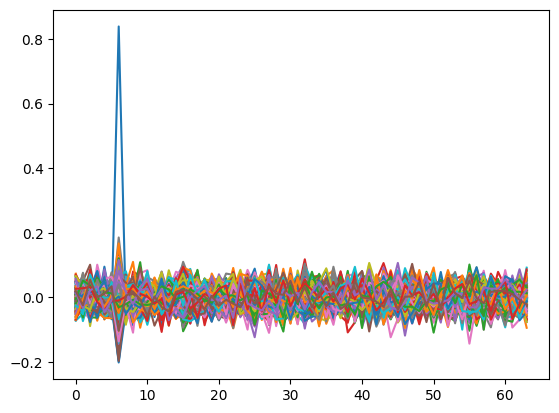

In [149]:
res = cpa(np.arange(256), messages, traces, lambda m,g :leakage_model(m, g, 0))
print("Correct key byte is ", res.max(1).argmax())
plt.plot(res.T)
plt.show()

Determine all the key bytes.

In [150]:
correct_key = []
for pos in range(16):
    key_byte = 0
    # TODO: find the correct key byte using CPA
    res = cpa(np.arange(256), messages, traces, lambda m,g :leakage_model(m, g, pos))
    key_byte = res.max(1).argmax()
    correct_key.append(key_byte)
    print("Key byte is: " + hex(key_byte))
print("Correct key is " + ':'.join([hex(b)[2:] for b in correct_key]))

Key byte is: 0x0
Key byte is: 0x1
Key byte is: 0x2
Key byte is: 0x3
Key byte is: 0x4
Key byte is: 0xca
Key byte is: 0xfe
Key byte is: 0x7
Key byte is: 0xde
Key byte is: 0xc0
Key byte is: 0xd
Key byte is: 0xed
Key byte is: 0xc
Key byte is: 0xd
Key byte is: 0xe
Key byte is: 0xf
Correct key is 0:1:2:3:4:ca:fe:7:de:c0:d:ed:c:d:e:f


# Comparison with DPA

The goal is to compare 2 different type of attacks and assess the fastest. Choose a byte to attack and determine how many curves are needed for CPA and for DPA to retrieve this key byte.

The best way to illustrate the two attacks is to plot the correct key rank versus number of curves.

## Rank CPA



1


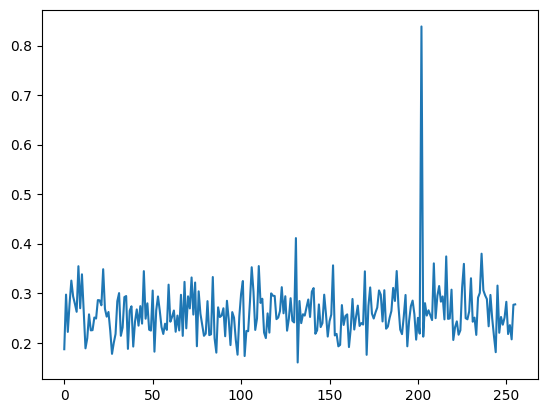

In [162]:
def rank_cpa(correct_key, nb_traces, byte_number):
    """
    correct key: the attacked byte of the actual correct key, that we retrieved in previous attack
    nb_traces: the number of trace to use in this attack
    byte_number: the position of the attacked byte in the key
    """
    rank = 0
    # TODO: find the rank for a given number of traces
    traces_subset = traces[:nb_traces]
    messages_subset = messages[:nb_traces]

    res = cpa(np.arange(256), messages_subset, traces_subset, lambda m,g :leakage_model(m, g, byte_number))

    peak_values_per_guess = np.max(np.abs(res), axis=1)

    sorted_guess_indices = np.argsort(peak_values_per_guess)[::-1]
    plt.plot(peak_values_per_guess)
    
    rank_index = np.where(sorted_guess_indices == correct_key)[0][0]

    rank = rank_index+1

    return rank

print(rank_cpa(0xca, 100, 5))

## Compare with DPA

Copy the DPA function from previous lab to get the correct key rank wih respect to the number of traces. 

In [165]:
# TODO: import all the functions needed for DPA (from previous lab)
# returns the value of bit_j of a byte
def target_function(msg, key, byte_i):
    ''' msg: 16 byte AES plaintext
        key: 1 byte of the AES key (your key guess)
        byte_i:  target byte position
        returns: 1 byte at the output of first SBOX
    '''
    intermediate_xor = msg[byte_i] ^ key
    sbox_output = SBOX[intermediate_xor]
    return sbox_output

def leakage_function(byte_i, bit_j):
    ''' byte: 
        bit: 
        returns: 0/1 
    '''
    return (byte_i >> bit_j) & 1

def selection(msg, key, byte_i, bit_j):
    ''' mess: message/plaintext
     key : key
     byte_n : the targeted byte
     bit_n : the targeted bit in the byte
     returns 0/1 
    '''
    intermediate_byte = target_function(msg, key, byte_i)
    return leakage_function(intermediate_byte, bit_j)
    
# sel0 is selection  with bit_j = 0 
# this function will be used fo further attacks
def sel0(msg, key, byte_i):
    return selection(msg, key, byte_i, 0)

def hypothesis(guess, messages, traces, selection_function):
    '''guess: key for this hypothesis
    messages: vector of n values 
    traces: matrix of traces (n . t)
    selection_function: a funtion which takes (m, k) as inputs and returns (0,1). You can use a lambda function derived from 
        the sel0 function
    returns hypothesis(vector)
    '''
    
    # TODO: build the hypothesis
    selection_bits = np.array([selection_function(m,guess) for m in messages], dtype=bool)

    traces_1 = traces[selection_bits]
    traces_0 = traces[~selection_bits]

    if len(traces_0) == 0 or len(traces_1) == 0:
        return np.zeros(traces.shape[1])

    mean_1 = np.mean(traces_1, axis=0)
    mean_0 = np.mean(traces_0, axis=0)

    
    # compute and return result
    return mean_1 - mean_0


def rank_dpa(correct_key, nb_traces, byte_number):
    """
    correct key: the attacked byte of the actual correct key, that we retrieved in previous attack
    nb_traces: the number of trace to use in this attack
    byte_number: the position of the attacked byte in the key
    """
    rank = 0
    # TODO: compute the correct rank for the given number of traces
    traces_subset = traces[:nb_traces]
    messages_subset = messages[:nb_traces]

    selection_func_n = lambda m, k, b=byte_number: sel0(m, k, b)
    num_samples = traces_subset.shape[1]
    num_guesses = 256
    h = np.zeros((num_guesses, num_samples))

    for guess in range(num_guesses):
        h[guess] = hypothesis(guess, messages_subset, traces_subset, selection_func_n)

    peak_values_per_guess = np.max(np.abs(h), axis=1)

    sorted_guess_indices = np.argsort(peak_values_per_guess)[::-1]

    rank_index = np.where(sorted_guess_indices == correct_key)[0][0]

    rank = rank_index+1

    return rank

## Plots

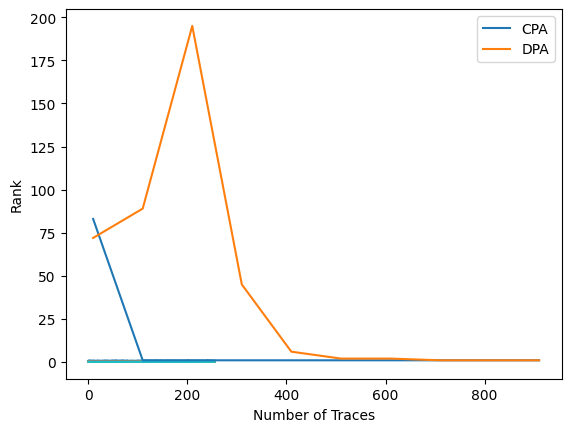

In [167]:
# Attacking on 5th byte of the key
byte_number = 5

plt.figure()

# using CPA
xc = range(10, 1000, 100)
yc = [rank_cpa(correct_key[byte_number], nb, byte_number) for nb in xc]
plt.plot(xc, yc, label='CPA')

# using DPA
xd = range(10, 1000, 100)
yd = [rank_dpa(correct_key[byte_number], nb, byte_number) for nb in xd]
plt.plot(xd, yd, label='DPA')

plt.xlabel("Number of Traces")
plt.ylabel("Rank")

plt.legend()
plt.show()

In [ ]:
## From this graph, we can conclude that running a CPA attack requires less traces compared to DPA, thus making CPA a much better option to run an AES attack. There's a weird blue thingy at the bottom, don't know why tho, but the shape of the graph looks convincing and expected.